In [1]:
using StateSpaceDynamics, Plots


In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.009189945184785569 0.03215941558734649; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863965 -0.10696223889695361], [-0.0037362031674817945 0.011184638740456908 … -0.07094318488635357 -0.05032349162445888; 0.01979088919057409 0.030620168627788782 … 0.03078518538867422 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.13735992748512493 0.03213684839745743; 0.042094688716242876 -0.10110240825174423 … -0.0663617447355249 -0.08508079724902799], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

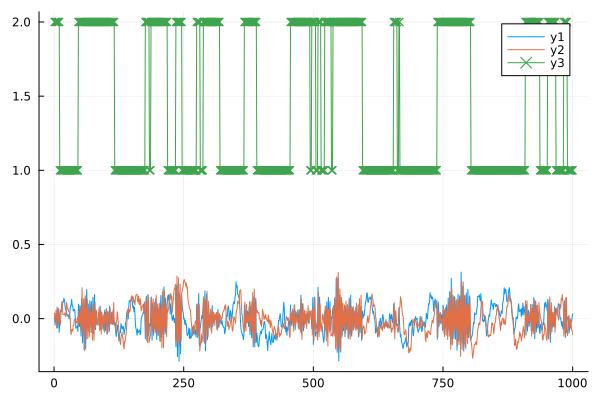

In [4]:
plot(x')
plot!(z, marker=:x)

In [5]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# set up the observation parameters
#C = randn(p, d)
#R = Matrix(0.5 * I(p))

C = model.B[1].obs_model.C
R = model.B[1].obs_model.R

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

#B = [StateSpaceDynamics.LinearDynamicalSystem(
#    StateSpaceDynamics.GaussianStateModel(model.B[i].state_model.A, model.B[i].state_model.Q, x0, P0),
#    StateSpaceDynamics.GaussianObservationModel(C, R),
#    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167399283 0.8337034337958541], [0.5 0.0; 0.0 0.5], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.4554

In [6]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [7]:
modeli.A

2×2 Matrix{Float64}:
 0.9  0.1
 0.2  0.8

In [8]:
K = modeli.K
T_step = size(y, 2)
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T_step)
FS = [StateSpaceDynamics.initialize_FilterSmooth(model.B[k], T_step) for k in 1:K]
ml = zeros(10)

for i in 1:length(ml)
    ml[i] = variational_expectation!(modeli, y, FB, FS)   
end

In [9]:
ml

10-element Vector{Float64}:
 -89482.32098337001
  -5551.781409972432
  -5069.086362320223
  -5060.643765222953
  -5060.643765222953
  -5060.643765222953
  -5060.643765222953
  -5060.643765222953
  -5060.643765222953
  -5060.643765222953

In [10]:
diff(ml) .>= 0

9-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1

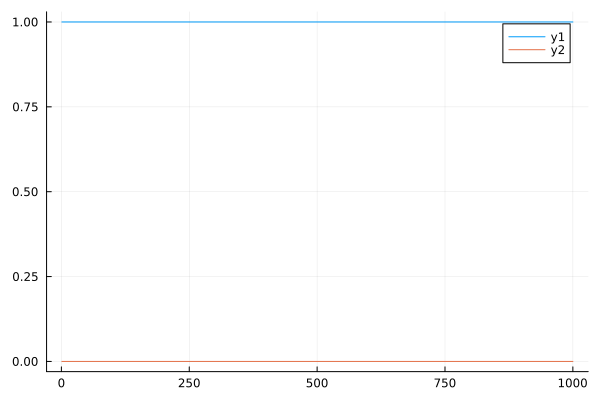

In [11]:
plot(exp.(FB.γ[1,:]))
plot!(exp.(FB.γ[2,:]))

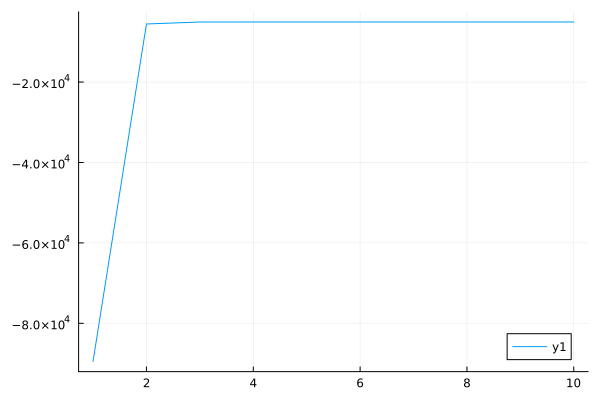

In [12]:
plot(ml)

In [9]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=2)

([-5060.643765222953, -4947.293712714186], [1.2696995262132647, 0.010021652810368738], StateSpaceDynamics.ForwardBackward{Float64}([-5.116252847358677 -5.561509092865718 … -5.387043576714699 -8.471778244476992; -4371.868503671616 -8324.529503794442 … -44773.20191582096 -44783.02768751283], [-5.116252847358677 -10.677761940224395 … -4938.821934469709 -4947.293712714186; -Inf -Inf … -Inf -Inf], [-4942.177459866841 -4936.615950773975 … -8.471778244476992 0.0; -4942.177459866841 -4936.615950773975 … -8.471778244476992 0.0], [0.0 0.0 … 0.0 0.0; -Inf -Inf … -Inf -Inf], [0.0 -Inf; -Inf -Inf;;; 0.0 -Inf; -Inf -Inf;;; 0.0 -Inf; -Inf -Inf;;; … ;;; 0.0 -Inf; -Inf -Inf;;; 0.0 -Inf; -Inf -Inf;;; 0.0 -Inf; -Inf -Inf]), StateSpaceDynamics.FilterSmooth{Float64}[StateSpaceDynamics.FilterSmooth{Float64}([0.00648435612806116 -0.04662350091027965 … 0.008339567643493785 0.03707236099367169; 0.016378013661136667 -0.03075719381072185 … -0.0868287866548141 -0.10244850476299895], [6.201878098460335e-5 -3.12739

In [10]:
param_diff

2-element Vector{Float64}:
 1.2696995262132647
 0.010021652810368738

In [11]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [12]:
modeli.A

2×2 Matrix{Float64}:
   1.0    0.0
 NaN    NaN

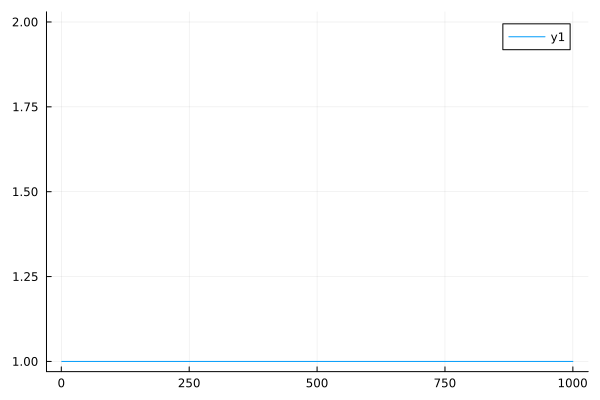

In [14]:
plot(exp.(FB.γ[1,:]))
#plot!(exp.(FB.γ[2,:]))

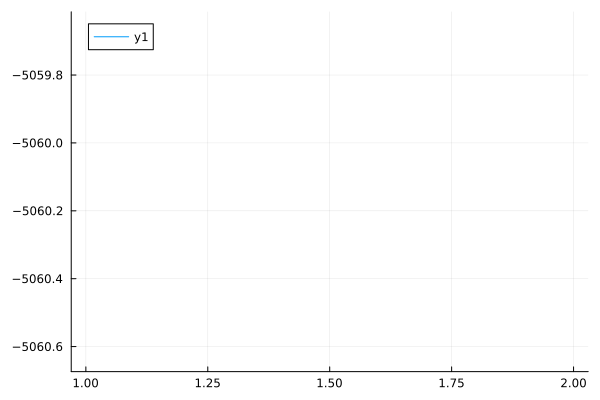

In [18]:
plot(mls)

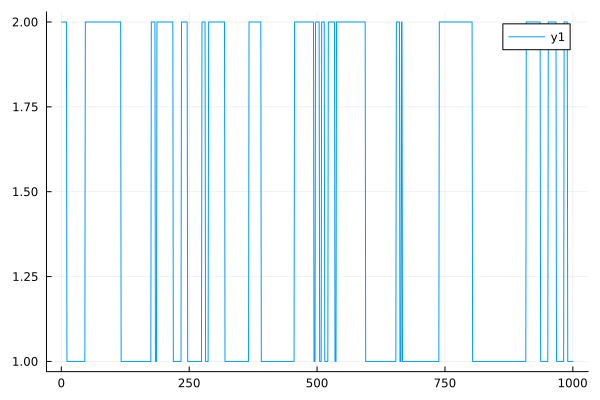

In [19]:
plot(z)

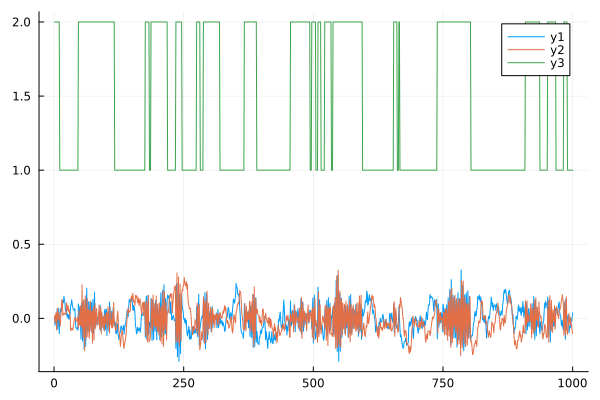

In [20]:
plot(FS[1].x_smooth')
plot!(z)

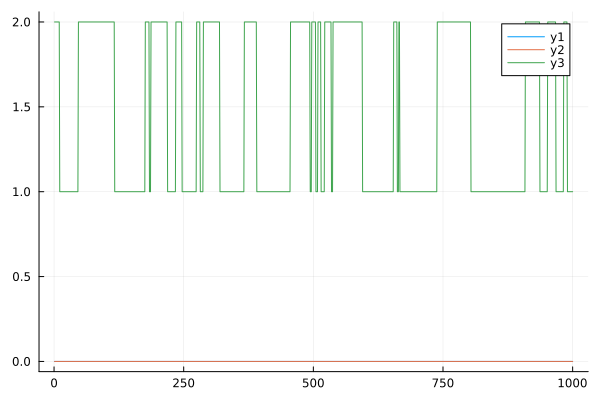

In [21]:
plot(FS[2].x_smooth')
plot!(z)

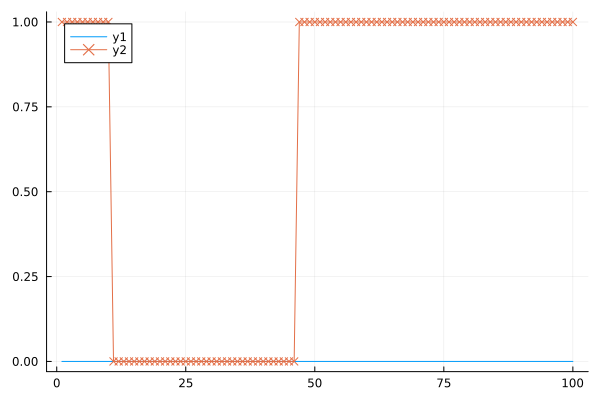

In [22]:
plot(exp.(FB.γ)'[1:100,2])
plot!(z[1:100] .- 1, marker=:x)

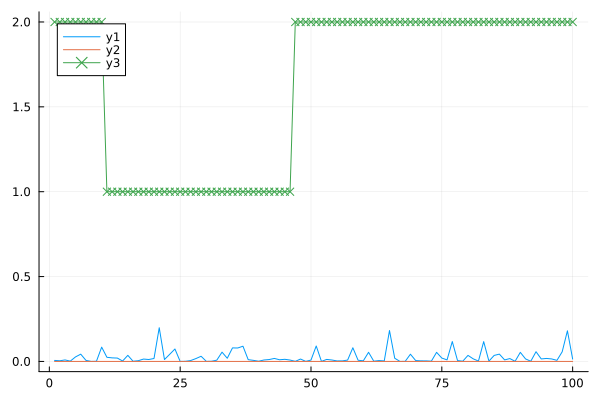

In [23]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

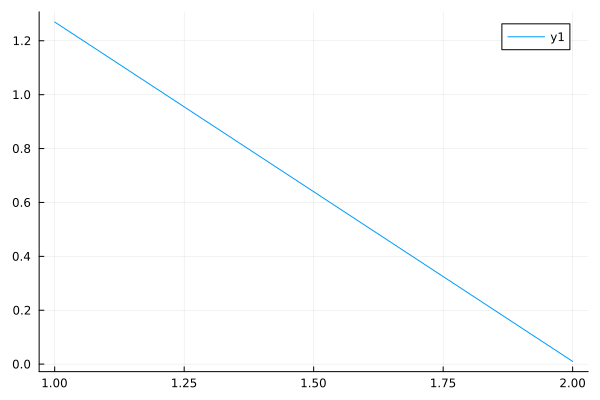

In [24]:
plot(param_diff)